# CI Log Data Predictions

### Imports/Spark Setup

In [8]:
from datetime import datetime

from gensim.corpora import Dictionary
from get_smarties import Smarties

from IPython.core.display import display, HTML
from IPython.display import clear_output

from keras.callbacks import History 
from keras.layers import Dense, Dropout
from keras.metrics import top_k_categorical_accuracy
from keras.models import Sequential,load_model
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
from pyspark.sql import SparkSession

import re
from sklearn import preprocessing
from sklearn.utils import class_weight
import tensorflow

spark = SparkSession.builder \
        .master("local") \
        .config("spark.executor.memory", '32g') \
        .config("spark.driver.memory", '32g') \
        .getOrCreate()

### Jupyter/Pandas Formatting

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=150)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

### Helpers

In [49]:
def percent(n):
    return int(round(n*100))

def percentStr(n):
    return str(round(n*100))+"%"

### Load/View Data

In [3]:
df=spark.read.parquet("rhci-moby.parquet")
df.printSchema()

root
 |-- @timestamp: timestamp (nullable = true)
 |-- __label: string (nullable = true)
 |-- ci_agent: struct (nullable = true)
 |    |-- label: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- ci_job: struct (nullable = true)
 |    |-- build_id: integer (nullable = true)
 |    |-- full_url: string (nullable = true)
 |    |-- log_url: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- phase: string (nullable = true)
 |    |-- status: string (nullable = true)
 |-- ci_master: struct (nullable = true)
 |    |-- hostname: string (nullable = true)
 |-- file: string (nullable = true)
 |-- geoip: struct (nullable = true)
 |    |-- location: struct (nullable = true)
 |    |    |-- lat: double (nullable = true)
 |    |    |-- lon: double (nullable = true)
 |-- hostname: string (nullable = true)
 |-- ipaddr4: string (nullable = true)
 |-- ipaddr6: string (nullable = true)
 |-- level: string (nullable = true)
 |-- message: string (nullable = true)
 

Let's look at one line:

In [4]:
df.take(1)

[Row(@timestamp=datetime.datetime(2016, 10, 19, 14, 43, 57), __label=None, ci_agent=None, ci_job=Row(build_id=429, full_url='https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redhat.com/job/QCI_1.1_RHEV_Conn_GUI-MLibVirt-QCI_OSE_CFME-Smoke-93f90/429/', log_url='http://shipshift.perf.lab.eng.bos.redhat.com/rhcs-jenkins.rhev-ci-vms.eng.rdu2.redhat.com/QCI_1.1_RHEV_Conn_GUI-MLibVirt-QCI_OSE_CFME-Smoke-93f90/429/rerun.txt', name='QCI_1.1_RHEV_Conn_GUI-MLibVirt-QCI_OSE_CFME-Smoke-93f90', phase='FINISHED', status='SUCCESS'), ci_master=None, file='rerun.txt', geoip=None, hostname=None, ipaddr4=None, ipaddr6=None, level='DEBUG', message='https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redhat.com/job/QCI_1.1_RHEV_Conn_GUI-MLibVirt-QCI_OSE_CFME-Smoke-93f90/429/rebuild', offset=0, payload_type=None, pid=None, pipeline_metadata=Row(@version='1', collector=None, normalizer=None, original_raw_message=None, trace='logstash'), port=45155, primary_change='QCI_OSE_CFME', rhci=Row(BKR_JOBID=None, EXISTING_NODES=None, 

### Sample
This dataset is huge, so let's only grab a million lines or so:

In [5]:
sample=df.sample(False,.005)
print(sample.count())

1115797


### Flatten
The data is in this horrible nested structure, so let's flatten the dataframe. This is kinda hacky, but it works pretty well.

In [6]:
#create new name for subfields
def addAlias(string):
    labelString = string.replace(".","_")
    return "sample['{}'].alias('{}')".format(string,labelString)

#recursively walk through schema and grab label of each subfield
def flattenSchema(schema,label):
    global selector
    for field in schema:
        if isinstance(field.dataType,pyspark.sql.types.StructType):
            flattenSchema(field.dataType,label+field.name+".")
        else:   
            if field.name != None:
                selector.append(addAlias(label+field.name))

#using array of subfield labels, generate code that will select each of these subfields
def createFlatFunc():
    global selector 
    selector = []
    flattenSchema(sample.schema,"")
    flattener = ",".join(selector)
    return "flatData = sample.select({})".format(flattener)

#execute the generated code
exec(createFlatFunc())

### Save/Load
Save our modifications to the dataframe from this point, to avoid having to run all this again. This is where all of the above will execute, so this will take a longish time.

In [7]:
save=True
if save:
    rhci = flatData.toPandas()
    rhci.to_pickle('rchiSample.pkl')
else:
    rhci = pd.read_pickle('rchiSample.pkl')

### Extract Some Neccesary Features
* The `tag` field is always a length-2 list, so assign those to different fields.
* The month the message was recorded in can be useful to split test/train sets, so let's grab that from `@timestamp`.
* We'll use the `ci_job_full_url` to uniquely identify jobs, and we'll take ~75% of unique jobs as our train set.
* Finally, we'll binarize `ci_job_status`; `SUCCESS` will map to 1, `FAILURE` to 0.

This one takes a *long* time

In [9]:
#grab tags
rhci['tag1']=rhci['tags'].apply(lambda x: x[0])
rhci['tag2']=rhci['tags'].apply(lambda x: x[1])

#grab month
rhci['month']=rhci['@timestamp'].apply(lambda x: x.to_pydatetime().month)

#assign train/test split
uniques = rhci['ci_job_full_url'].unique()
print("Number of unique urls:",len(uniques))
thresh=.75
print("Number of jobs in training set:",len(uniques)*thresh)
trainIDs = np.random.choice(uniques,size=int(len(uniques)*thresh),replace=False)
rhci['train'] = rhci['ci_job_full_url'].apply(lambda x: 1 if x in trainIDs else 0)
print("Total messages in train/test set:",rhci['train'].value_counts())

#map status to integer
rhci['status']=rhci['ci_job_status'].apply(lambda x: 1 if x=="SUCCESS" else 0)
rhci = rhci.sample(frac=1)

Number of unique urls: 54198
Number of jobs in training set: 40648.5
Total messages in train/test set: 1    845213
0    270584
Name: train, dtype: int64


### Process columns based on number of unique values
Here we perform the most important parts of the analysis; we separate well-specified and overspecified columns into separate processing pipelines. First, we assign a threshold $t$ (usually around 100). Then we count the number of unique values $N_u$ in each column, and apply the following rules:

* If $N_u$ is 1 or 0, drop the column; a column with one value or no values cannot be used to distinguish success or failures. 
* If $N_u>t$, assign column to the overspecified pipeline.
* Else, assign column to well-specified pipeline.

Additionally, the columns used for splitting train and test sets are removed, to prevent any overfitting weirdness.

In [19]:
def preprocess(t=100):
    tagExpand=rhci.drop(['tags','ci_job_status'],axis=1)
    
    drops,overspec=[],[]
    
    #split well-specified and over-specified columns
    print("====================")
    for column in tagExpand.columns:     
        
        #remove under/overspecified columns
        N_u = len(tagExpand[column].unique())
        
        #drop completely null columns
        if N_u==0 or N_u==1:
            drops.append(column)
                  
        #drop test/train identifier columns
        elif column in ['@timestamp','ci_job_full_url']:
            drops.append(column)
                
        #move overspecified columns to seperate pipelines
        elif N_u>t:
            overspec.append(column)
            drops.append(column)

    print("Overspecified Columns:",overspec)
    
    #seperate data into train and test sets
    test = tagExpand[tagExpand['train']==0]
    train= tagExpand[tagExpand['train']==1]
       
    #grab well-spec and over-spec test and train sets
    well_spec_train,well_spec_test=train.drop(drops,axis=1),test.drop(drops,axis=1)
    overspec_train,overspec_test  = train[overspec],test[overspec]
        
    print("====================")
    return well_spec_train,well_spec_test,overspec_train,overspec_test     

well_spec_train,well_spec_test,overspec_train,overspec_test=preprocess()

Overspecified Columns: ['ci_job_build_id', 'ci_job_log_url', 'ci_job_name', 'file', 'hostname', 'ipaddr4', 'message', 'offset', 'rhci_BKR_JOBID', 'rhci_JSLAVELABEL', 'rhci_JSLAVENAME', 'rhci_LABEL', 'rhci_PROVISION_JOB']


### One-Hot
Well-specified columns are passed to a one-hot vectorizer.

In [44]:
def onehot(train,test):
    gs = Smarties()
    toDummy = [x for x in train.columns if x not in ["month","status","train"]]
    dummiedTrain = gs.fit_transform(train,columns=toDummy).reset_index(drop=True)
    dummiedTest  = gs.transform(test).reset_index(drop=True)
    return dummiedTrain,dummiedTest

oh_train,oh_test = onehot(well_spec_train,well_spec_test)

### Bag-of-Words
Overspecified columns are split by common string separators in the log messages (commas, brackets, etc) and all the overspecified columns are joined into a single list of strings. This list of strings is passed into a bag-of-words vectorizer. The word frequency threshold of the vectorizer is automatically adjusted until there are between 200 and 400 words in the bag-of-words.

In [42]:
#split strings by common word separators found in log messages
def stringMap(items):
    splitString = "[, ]+"
    mapped = re.split(splitString," ".join([str(x) for x in items]))
    return [mapped]

def BoW(train,test,below,above):
    train = [x[0] for x in train.apply(lambda x: stringMap(x),axis=1).values.tolist()]
    test  = [x[0] for x in test.apply(lambda x: stringMap(x),axis=1).values.tolist()]
    
    bowSize = 0
    while bowSize<200 or bowSize>400:
        dct=Dictionary(train)
        dct.filter_extremes(no_below=int(below), no_above=above)
        print("BoW Size:",len(dct))
        bowSize = len(dct)
        
        if bowSize<200:
            below*=.75
            print("-> Decreasing frequency thresh to {}...".format(int(below)))
        if bowSize>400:
            below*=1.25
            print("-> Increasing frequency thresh to {}...".format(int(below)))
    
    print("Bag of Words:")
    [print(i,":",val) for i,val in enumerate(list(dct.itervalues()))]
    trainBOW=[dct.doc2bow(x) for x in train]
    testBOW=[dct.doc2bow(x) for x in test]
    
    return trainBOW,testBOW,len(dct)

#cast bag-of-words vectors into a pandas df
def vectorize(df,size):
    outs = []
    for row in df:
        out = np.zeros(size)
        for field in row:
            #print(field[0],field[1])
            out[field[0]]=field[1]
        outs.append(out)
    outDF= pd.DataFrame(outs)
    return outDF

bow_train_raw,bow_test_raw,size=BoW(overspec_train,overspec_test,below=500,above=.9)
bow_train,bow_test=vectorize(bow_train_raw,size),vectorize(bow_test_raw,size)

BoW Size: 1437
-> Increasing below thresh to 625...
BoW Size: 1288
-> Increasing below thresh to 781...
BoW Size: 1092
-> Increasing below thresh to 976...
BoW Size: 874
-> Increasing below thresh to 1220...
BoW Size: 665
-> Increasing below thresh to 1525...
BoW Size: 519
-> Increasing below thresh to 1907...
BoW Size: 435
-> Increasing below thresh to 2384...
BoW Size: 379
0 : "provider_release":
1 : "rhcloudforms-3.1"
2 : 28
3 : None
4 : iits-Project_Planner_Extract-Reporter-iits_recheck-stage-07b81
5 : interop_merge_results_2016-10-16_00-36-05.json
6 : -
7 : QCI_1.1_RHEV_SH_API-MLibVirt-QCI-Smoke-f188a-stable-runtest
8 : consoleText
9 : nan
10 : -->
11 : Dependency:
12 : Interop-OSP_9-MLibVirt-smoke-b3f3d-stable-provision
13 : Processing
14 : for
15 : package:
16 : pet-pit-slave
17 : "Supported"
18 : "expected_value":
19 : 92
20 : (1):
21 : HTTPS
22 : INFO
23 : Starting
24 : connection
25 : new
26 : requests.packages.urllib3.connectionpool
27 : rhcs-jenkins.rhev-ci-vms.eng.rdu2.red

### Join data from one-hot and BoW pipelines

In [45]:
def dataJoin(trainBOW,trainOH,testBOW,testOH,join):
    if join:
        train=pd.concat([trainOH,trainBOW], axis=1)
        test=pd.concat([testOH,testBOW], axis=1)
    else:
        train=trainOH
        test=testOH
    
    features = [x for x in train.columns if x not in ["month","status","train"]]
    testX= test.loc[:,features].as_matrix()
    testY= test["status"].as_matrix()
    trainX= train.loc[:,features].as_matrix()
    trainY= train["status"].as_matrix()

    print("TRAIN | X Shape:",trainX.shape,"| Y Shape: ",trainY.shape)
    print("TEST  | X Shape:",testX.shape,"| Y Shape: ",testY.shape)
    print()
    
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY=dataJoin(bow_train,oh_train,bow_test,oh_test,join=True)

TRAIN | X Shape: (845213, 639) | Y Shape:  (845213,)
TEST  | X Shape: (270584, 639) | Y Shape:  (270584,)



### Net Model
Define a simple feed-forward fully-connected network with a variable number and size of hidden layers.

In [47]:
def NN_Model(data,epochs,hiddenSize,batchsize):
    trainX,trainY,testX,testY=data
    model = Sequential()

    #hidden layers
    model.add(Dense(hiddenSize[0], input_dim=trainX.shape[1],kernel_initializer='normal',activation='relu'))
    model.add(Dropout(.1))
        
    if len(hiddenSize)>1:
        for h in hiddenSize[1:]:
            model.add(Dense(h,activation='relu',kernel_initializer='normal'))
            model.add(Dropout(.1))        

    model.add(Dense(1, activation='sigmoid',kernel_initializer='normal'))
    
    model.compile(optimizer='AdaGrad',
        loss='binary_crossentropy',
        metrics=['accuracy'])

    #train
    class_weights = class_weight.compute_class_weight('balanced',np.unique(trainY),trainY)
    history = History()    
    model.fit(trainX, trainY, epochs=epochs, batch_size=batchsize,validation_data=(testX,testY),class_weight=class_weights,callbacks=[history])
    return history,model

### Test Statistics
Get a sense of the shape of the test and train data, as well as the distribution of success and failure in each set.

In [50]:
#data stats
train_0,train_1 = np.bincount(trainY)
train_len=len(trainY)
test_0,test_1  = np.bincount(testY)
test_len = len(testY)

print("TRAIN | 0: {} 1: {} | {}% vs {}%".format(train_0,train_1,percent(train_0/train_len),percent(train_1/train_len)))
print("TEST  | 0: {} 1: {} | {}% vs {}%".format(test_0,test_1,percent(test_0/test_len),percent(test_1/test_len)))
minAcc = max(percent(test_0/test_len),percent(test_1/test_len))
print("Minimum acceptable test acc: {}%".format(minAcc))
print()

TRAIN | 0: 332413 1: 512800 | 39% vs 61%
TEST  | 0: 110016 1: 160568 | 41% vs 59%
Minimum acceptable test acc: 59%



### Train the Neural Net (Finally!)

This is such a simple net it trains pretty well in a single epoch. The net will output a value between 0 and 1 for each log message, with 0 meaning the net is confident of CI failure while 1 refers to confident CI success. It's a probability of sorts; a prediction of 0 can be thought of a predicted 0% chance of success, etc.

In [51]:
data=[trainX,trainY,testX,testY]
history,model = NN_Model(data,1,[128],batchsize=256)
print("Max Acc:",max(history.history['val_acc']))

Train on 845213 samples, validate on 270584 samples
Epoch 1/1
845213/845213 [==============================] - 37s 43us/step - loss: 0.1349 - acc: 0.9448 - val_loss: 0.2443 - val_acc: 0.8858
Max Acc: 0.8858099517885566


### Evaluate net performance with some stock metrics
Since we want to early terminate jobs that are predicted to fail, we need to make sure we're very confident in failure prediction. To this end, we need to ensure we have a very low *false-negative rate*, and we do this by assigning a *threshold of certainty* of around 0.1. Only jobs with a predicted success rate less than this threshold get marked as failure, while all other jobs get marked as success. This raises the false-positive rate, that is, more destined-to-fail jobs escape early termination but this is okay; letting destined-to-fail jobs run to failure is the current default behavior.

===TRAIN===
Accuracy:  93.0%
True Pos:  512506 100.0%
False Neg: 294 0.0%
True Neg:  271775 82.0%
False Pos: 60638 18.0%

===TEST===
Accuracy:  85.0%
True Pos:  160451 100.0%
False Neg: 117 0.0%
True Neg:  68327 62.0%
False Pos: 41689 38.0%

             precision    recall  f1-score   support

          0       1.00      0.62      0.77    110016
          1       0.79      1.00      0.88    160568

avg / total       0.88      0.85      0.84    270584



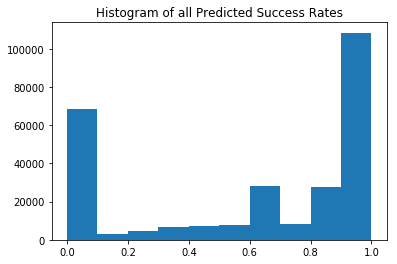

In [52]:
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm

def roundThresh(arr,thresh):
    return arr>thresh

def printCM(cmMatrix):
    tn, fp, fn, tp = cmMatrix.ravel()
    print("Accuracy: ",percentStr((tp+tn)/(tp+tn+fn+fp)))
    print("True Pos: ",tp,percentStr(tp/(tp+fn)))
    print("False Neg:",fn,percentStr(fn/(tp+fn)))
    print("True Neg: ",tn,percentStr(tn/(tn+fp)))
    print("False Pos:",fp,percentStr(fp/(tn+fp)))
    
def classifierReport(model,data,thresh):
    trainX,trainY,testX,testY=data
    
    thresh=.1
    trainPreds= roundThresh(model.predict(trainX),thresh)
    testPreds = roundThresh(model.predict(testX),thresh)

    print("===TRAIN===")
    printCM(cm(trainY,trainPreds))
    print("\n===TEST===")
    printCM(cm(testY,testPreds))
    print()
    print(cr(testY,testPreds))
    return trainPreds,testPreds
    
trainPreds,testPreds=classifierReport(model,data,.1)

plt.hist(model.predict(testX))
plt.title("Histogram of all Predicted Success Rates")
plt.show()

# The Simulator
However while a test accuracy of 85% is neat, the log messages aren't taken in isolation but rather they arrive in *sequence*. This means that any future predictions on a job that's already been early terminated don't matter; we've already gotten it right or wrong. As such, we need to design a simulation that mirrors how log messages actually appear. As such, we group messages by job and then feed them sequentially into the network. When the net predicts failure, we early terminate the job, and we therefore can't consider any future log messages that are generated. We then measure our performance in this new scenario, as well as consider the time saved by correct early-termination and time wasted by incorrect early-termination and resultant re-running of such jobs.

In [53]:
#add predictions to test set dataframe
testSet = rhci[rhci['train']==0]
testSet['pred']=testPreds.astype(int)

def listify(x):
    return list(x)

def uniques(x):
    return len(np.unique(x))

#group jobs by ci_job_full_url, concatenate all statuses,predictions into lists
testSetGroups=testSet.sort_values(by='@timestamp').groupby('ci_job_full_url')['ci_job_full_url','@timestamp','status','pred'].agg({'list':listify,'uniques': uniques})

#grab end-run status of job
testSetGroups['status']=testSetGroups['list','status'].apply(max)

#calculate total runtime of jobs
testSetGroups['runtime']=testSetGroups.apply(lambda x: (x['list','@timestamp'][-1]-x['list','@timestamp'][0]).total_seconds(),axis=1)

#
#testSetGroups=testSetGroups[testSetGroups['uniques','status']==1]
testSetGroups[testSetGroups['uniques','@timestamp']>1].sort_values(by='runtime',ascending=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


list  \
                                                                                      ci_job_full_url   
ci_job_full_url                                                                                         
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.redha...  [https://rhcs-jenkins.rhev-ci-vms.eng.rdu2.red...   
ht

### Compute time saved by early-termination

In [54]:
outcomes = ['TrueNeg', 'FalsePos', 'FalseNeg', 'TruePos']

def timeSaved(x):
    #grab first and last timestamp,runtime
    lastT  = x['list','@timestamp'][-1]
    firstT  = x['list','@timestamp'][0]
    runtime = (lastT-firstT).total_seconds()
    
    #look through predictions for negative preds
    for i,pred in enumerate(x['list','pred']):
        if pred==0:
            elapsed=(x['list','@timestamp'][i]-firstT).total_seconds()
            left=(lastT-x['list','@timestamp'][i]).total_seconds()
            if x['status'][0]==0:
                result = "TrueNeg"
                return result,elapsed,left,runtime
            if x['status'][0]==1:
                result = "FalseNeg"
                return result,elapsed,left,runtime
                
    
    #if no negative preds, assume run finished
    elapsed=runtime
    left=0.
    
    if x['status'][0]==1:
        result="TruePos"
    
    if x['status'][0]==0:
        result="FalsePos"
    
    return result,elapsed,left,runtime
    
def runTests():
    results = []
    elapseds = []
    lefts = []
    runtimes = []

    toTest = testSetGroups
    for i in range(len(toTest.index)):
        test = toTest.iloc[i]
        result,elapsed,left,runtime=timeSaved(test)
        
        results.append(result)
        elapseds.append(elapsed)
        lefts.append(left)
        runtimes.append(runtime)

    return pd.DataFrame({'result':results,'elapsed':elapseds,'left':lefts,'runtime':runtimes})
    
runtestDF = runTests()

### Display simulation results

The simulator outputs five values:
* `Time Remaining`: If nonzero, the how much longer a CI job would have run where it not early terminated. If zero, indicates the job ran to completion
* `Time Spent`: The total time spent on this particular job until early-termination/completion
* `Total Runtime`: The total time a CI job would have taken if it was allowed to run to completion without early termination
* `T_Spent/Total`: The amount of time spent on jobs *with* early termination versus the amount of time the jobs would have taken *without* early termination.
* `T_Left/Total:`The amount of time saved *by* early termination versus the amount of time the jobs would have taken *without* early termination.


In this run of the simulation, the CI jobs ran for a total of 6 hours and 52 minutes (see `Total: Time Spent`), with 2 hours and 21 minutes saved by early termination (see `Total: Time Remaining`). False-negative early terminations wasted only 8 minutes (see `False Neg: Time Spent` and `False Neg: Total Runtime`). As such, running these jobs with early-termination would improve total runtime by around 26%.

In [56]:
def showTime(t):
    if t/60>120:
        hours= int(t/60/60)
        mins = (t/60)%60
        return str(hours)+" hrs "+str(int(mins))+" min"
    if t<120:
        return str(int(t))+" sec"
    else:
        return str(int(t/60))+" min"

resultNames = ['','Pos','Neg','TruePos','TrueNeg','FalsePos','FalseNeg']
for resultName in resultNames:
    
    if resultName ==  "":
        print("==== Total ====")
        check = runtestDF
    elif len(resultName)==3:
        print("====",resultName,"====")
        check = runtestDF[runtestDF['result'].isin(['True'+resultName,"False"+resultName])]
    else:
        print("====",resultName,"====")
        check = runtestDF[runtestDF['result']==resultName]
    
    print(check.describe())
    leftSum=check['left'].sum()
    elapSum=check['elapsed'].sum()
    runSum =check['runtime'].sum()
    
    print("\nTime Remaining:",showTime(leftSum))
    print("Time Spent:    ",showTime(elapSum))
    print("Total Runtime: ",showTime(runSum))
    print("T_Spent/Total: ",percentStr(elapSum/runSum))
    print("T_Left/Total:  ",percentStr(leftSum/runSum))
    print("\n")

==== Total ====
           elapsed          left       runtime
count  13550.00000  13550.000000  13550.000000
mean       1.82645      0.626319      2.452769
std       23.06005      3.758853     23.318047
min        0.00000      0.000000      0.000000
25%        0.00000      0.000000      0.000000
50%        0.00000      0.000000      0.000000
75%        0.06500      0.000000      0.225000
max     2413.24200    121.286000   2413.242000

Time Remaining: 2 hrs 21 min
Time Spent:     6 hrs 52 min
Total Runtime:  9 hrs 13 min
T_Spent/Total:  74.0%
T_Left/Total:   26.0%


==== Pos ====
            elapsed     left       runtime
count  11970.000000  11970.0  11970.000000
mean       2.039236      0.0      2.039236
std       24.494552      0.0     24.494552
min        0.000000      0.0      0.000000
25%        0.000000      0.0      0.000000
50%        0.000000      0.0      0.000000
75%        0.106000      0.0      0.106000
max     2413.242000      0.0   2413.242000

Time Remaining: 0 sec
Tim